# Caso Práctico: Naive Bayes 

En este ejercicio se muestran los fundamentos del algoritmo Naive Bayes planteando a uno de los primeros problemas que fueron solucionados mediante el uso de técnicas de Machine Learning: la detección de SPAM.

## Enunciado del ejercicio: Detección de SPAM

Se propone la construcción de un sistema de aprendizaje automático capaz de predecir si un correo determinado se corresponde con un correo de SPAM o no, para ello, se utilizará el siguiente conjunto de datos:

##### [2007 TREC Public Spam Corpus](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo07)
The corpus trec07p contains 75,419 messages:

    25220 ham
    50199 spam

These messages constitute all the messages delivered to a particular
server between these dates:

    Sun, 8 Apr 2007 13:07:21 -0400
    Fri, 6 Jul 2007 07:04:53 -0400

## 1. Funciones auxiliares

En este caso práctico relacionado con la detección de correos electrónicos de SPAM, el conjunto de datos que disponemos esta formado por correos electrónicos, con sus correspondientes cabeceras y campos adicionales. Por lo tanto, requieren un preprocesamiento previo a que sean ingeridos por el algoritmo de Machine Learning.

In [1]:
# Esta clase facilita el preprocesamiento de correos electrónicos que poseen código HTML
from html.parser import HTMLParser


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return ''.join(self.fed)

In [2]:
# Esta función se encarga de elimar los tags HTML que se encuentren en el texto del correo electrónico
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
# Ejemplo de eliminación de los tags HTML de un texto
t = '<tr><td align="left"><a href="../../issues/51/16.html#article">Phrack World News</a></td>'
strip_tags(t)

'Phrack World News'

Además de eliminar los posibles tags HTML que se encuentren en el correo electrónico, deben realizarse otras acciones de preprocesamiento para evitar que los mensajes contengan ruido innecesario. Entre ellas se encuentra la eliminación de los signos de puntuación, eliminación de posibles campos del correo electrónico que no son relevantes o eliminación de los afijos de una palabra manteniendo únicamente la raiz de la misma (Stemming). La clase que se muestra a continuación realiza estas transformaciones.

In [4]:
import email
import string
import nltk

class Parser:

    def __init__(self):
        self.stemmer = nltk.PorterStemmer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = list(string.punctuation)

    def parse(self, email_path):
        """Parse an email."""
        with open(email_path, errors='ignore') as e:
            msg = email.message_from_file(e)
        return None if not msg else self.get_email_content(msg)

    def get_email_content(self, msg):
        """Extract the email content."""
        subject = self.tokenize(msg['Subject']) if msg['Subject'] else []
        body = self.get_email_body(msg.get_payload(),
                                   msg.get_content_type())
        content_type = msg.get_content_type()
        # Returning the content of the email
        return {"subject": subject,
                "body": body,
                "content_type": content_type}

    def get_email_body(self, payload, content_type):
        """Extract the body of the email."""
        body = []
        if type(payload) is str and content_type == 'text/plain':
            return self.tokenize(payload)
        elif type(payload) is str and content_type == 'text/html':
            return self.tokenize(strip_tags(payload))
        elif type(payload) is list:
            for p in payload:
                body += self.get_email_body(p.get_payload(),
                                            p.get_content_type())
        return body

    def tokenize(self, text):
        """Transform a text string in tokens. Perform two main actions,
        clean the punctuation symbols and do stemming of the text."""
        for c in self.punctuation:
            text = text.replace(c, "")
        text = text.replace("\t", " ")
        text = text.replace("\n", " ")
        tokens = list(filter(None, text.split(" ")))
        # Stemming of the tokens
        return [self.stemmer.stem(w) for w in tokens if w not in self.stopwords]

##### Lectura de un correo en formato raw

In [5]:
inmail = open("datasets/trec07p/data/inmail.1").read()
#print(inmail)

##### Parsing del correo electrónico

In [6]:
p = Parser()
p.parse("datasets/trec07p/data/inmail.1")

{'subject': ['gener', 'ciali', 'brand', 'qualiti'],
 'body': ['do',
  'feel',
  'pressur',
  'perform',
  'rise',
  'occas',
  'tri',
  'viagra',
  'anxieti',
  'thing',
  'past',
  'back',
  'old',
  'self'],
 'content_type': 'multipart/alternative'}

##### Lectura del índice

Estas funciones complementarias se encargan cargar en memoria la ruta de cada correo electrónico y su etiqueta correspondiente {spam, ham}

In [24]:
index = open("datasets/trec07p/full/index").readlines()
#index

In [8]:
import os

DATASET_PATH = "datasets/trec07p"

def parse_index(path_to_index, n_elements):
    ret_indexes = []
    index = open(path_to_index).readlines()
    for i in range(n_elements):
        mail = index[i].split(" ../")
        label = mail[0]
        path = mail[1][:-1]
        ret_indexes.append({"label":label, "email_path": os.path.join(DATASET_PATH, path)})
    return ret_indexes

In [9]:
def parse_email(index):
    p = Parser()
    pmail = p.parse(index["email_path"])
    return pmail, index["label"]

In [10]:
indexes = parse_index("datasets/trec07p/full/index", 10)
indexes

[{'label': 'spam', 'email_path': 'datasets/trec07p\\data/inmail.1'},
 {'label': 'ham', 'email_path': 'datasets/trec07p\\data/inmail.2'},
 {'label': 'spam', 'email_path': 'datasets/trec07p\\data/inmail.3'},
 {'label': 'spam', 'email_path': 'datasets/trec07p\\data/inmail.4'},
 {'label': 'spam', 'email_path': 'datasets/trec07p\\data/inmail.5'},
 {'label': 'spam', 'email_path': 'datasets/trec07p\\data/inmail.6'},
 {'label': 'spam', 'email_path': 'datasets/trec07p\\data/inmail.7'},
 {'label': 'spam', 'email_path': 'datasets/trec07p\\data/inmail.8'},
 {'label': 'spam', 'email_path': 'datasets/trec07p\\data/inmail.9'},
 {'label': 'ham', 'email_path': 'datasets/trec07p\\data/inmail.10'}]

## 2. Preprocesamiento de los datos del conjunto de datos

Con las funciones presentadas anteriormente se permite la lectura de los correos electrónicos de manera programática y el procesamiento de los mismos para eliminar aquellos componentes que no resultan de utilidad para la detección de correos de SPAM. Sin embargo, cada uno de los correos sigue estando representado por un diccionario de Python con una serie de palabras.

In [11]:
# Cargamos el índice y las etiquetas en memoria
index = parse_index("datasets/trec07p/full/index", 1)

In [12]:
# Leemos el primer correo
open(index[0]["email_path"]).read()

'From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007\nReturn-Path: <RickyAmes@aol.com>\nReceived: from 129.97.78.23 ([211.202.101.74])\n\tby speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;\n\tSun, 8 Apr 2007 13:07:21 -0400\nReceived: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100\nMessage-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>\nFrom: "Tomas Jacobs" <RickyAmes@aol.com>\nReply-To: "Tomas Jacobs" <RickyAmes@aol.com>\nTo: the00@speedy.uwaterloo.ca\nSubject: Generic Cialis, branded quality@ \nDate: Sun, 08 Apr 2007 21:00:48 +0300\nX-Mailer: Microsoft Outlook Express 6.00.2600.0000\nMIME-Version: 1.0\nContent-Type: multipart/alternative;\n\tboundary="--8896484051606557286"\nX-Priority: 3\nX-MSMail-Priority: Normal\nStatus: RO\nContent-Length: 988\nLines: 24\n\n----8896484051606557286\nContent-Type: text/html;\nContent-Transfer-Encoding: 7Bit\n\n<html>\n<body bgcolor="#ffffff">\n<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0

In [13]:
# Parseamos el primer correo
mail, label = parse_email(index[0])
print("El correo es:", label)
print(mail)

El correo es: spam
{'subject': ['gener', 'ciali', 'brand', 'qualiti'], 'body': ['do', 'feel', 'pressur', 'perform', 'rise', 'occas', 'tri', 'viagra', 'anxieti', 'thing', 'past', 'back', 'old', 'self'], 'content_type': 'multipart/alternative'}


El algoritmo Naive Bayes no es capaz de ingerir texto como parte del conjunto de datos. Por lo tanto, deben aplicarse una serie de funciones adicionales que transformen el texto de los correos electrónicos parseados en una representación numérica.

##### Aplicación de CountVectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Preapración del email en una cadena de texto
prep_email = [" ".join(mail['subject']) + " ".join(mail['body'])]

vectorizer = CountVectorizer()
X = vectorizer.fit(prep_email)

#print("Features:\n", vectorizer.get_feature_names())

In [15]:
X = vectorizer.transform(prep_email)
print("\nValues:\n", X.toarray())


Values:
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


##### Aplicación de OneHotEncoding

In [16]:
from sklearn.preprocessing import OneHotEncoder

prep_email = [[w] for w in mail['subject'] + mail['body']]

enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(prep_email)

#print("Features:\n", enc.get_feature_names())
print("\nValues:\n", X.toarray())


Values:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

##### Funciones auxiliares para preprocesamiento del conjunto de datos

In [17]:
def create_prep_dataset(index_path, n_elements):
    X = []
    y = []
    indexes = parse_index(index_path, n_elements)
    for i in range(n_elements):
        print("\rParsing email: {0}".format(i+1), end='')
        mail, label = parse_email(indexes[i])
        X.append(" ".join(mail['subject']) + " ".join(mail['body']))
        y.append(label)
    return X, y

## 3. Entrenamiento del algoritmo 

In [18]:
x_train, y_train = create_prep_dataset("datasets/trec07p/full/index", 100)
#x_train

Parsing email: 100

##### Aplicamos la vectorización a los datos

In [19]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(x_train)

In [20]:
print(X_train.toarray())
print("\nFeatures:", len(vectorizer.get_feature_names_out()))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Features: 4987


In [21]:
import pandas as pd

pd.DataFrame(X_train.toarray(), columns=[vectorizer.get_feature_names_out()])

,0000,000000,00085,002,003,00450,009,01,01000u,0107,...,õôõôèõéï,ö¹,öð,öôööµæ,öø³ðåµ,öþ,öˆ,úàí,þîñòµ¼,šè
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#y_train

**Entrenamiento del algoritmo Naive Bayes con el conjunto de datos preprocesado**

In [23]:
from sklearn.naive_bayes import BernoulliNB

nb_clf = BernoulliNB(alpha=1.0e-10)
nb_clf.fit(X_train,y_train)

BernoulliNB(alpha=1e-10)

## 4. Predicción

##### Lectura de un conjunto de correos nuevos

In [26]:
X, y = create_prep_dataset("datasets/trec07p/full/index",500)
X_test = X[100:]
y_test = y[100:]

Parsing email: 500

##### Preprocesamiento de los correos con el vectorizador creado anteriormente

In [27]:
X_test = vectorizer.transform(X_test)

##### Predicción del tipo de correo

In [29]:
y_pred = nb_clf.predict(X_test)
#y_pred

##### Evaluación de los resultados

In [31]:
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(y_test,y_pred, pos_label = "ham"))

F1 Score: 0.7238095238095238


## 5. Aumentando el conjunto de datos

In [33]:
X, y = create_prep_dataset("datasets/trec07p/full/index", 12000)

Parsing email: 12000

In [34]:
X_train, y_train = X[:10000], y[:10000]
X_test, y_test = X[10000:], y[10000:]

In [35]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)

In [36]:
nb_clf = BernoulliNB(alpha=1.0e-10)
nb_clf.fit(X_train,y_train)

BernoulliNB(alpha=1e-10)

In [37]:
X_test = vectorizer.transform(X_test)

In [38]:
y_pred = nb_clf.predict(X_test)

In [39]:
print("F1 Score:", f1_score(y_test,y_pred, pos_label = "ham"))

F1 Score: 0.9333333333333333


## 6. Representación gráfica del límite de decisión

Representamos el límite de decisión que generan este tipo de algoritmos mediante el uso de un conjunto de datos más sencillo y con menos características de entrada.

In [40]:
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec

def plot_decision_boundary(X, y, clf):
    mins = X.min(axis=0) - 0.5
    maxs = X.max(axis=0) + 0.5  

    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 71),
                     np.linspace(mins[1], maxs[1], 81))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    gs = gridspec.GridSpec(1, 2)
    gs.update(hspace=0.8)
    
    ax = plt.subplot(gs[0])
    ax.contourf(xx, yy, Z, cmap="RdBu", alpha=0.5)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.')
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], 'b.')
    
    ax = plt.subplot(gs[1])
    ax.contour(xx, yy, Z, [0.5], colors='k')
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.')
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], 'b.')

In [53]:
#Generamos un conjunto de datos más sencillo
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris["data"][:,(2,3)]
y = (iris["target"]==2).astype(np.int32)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

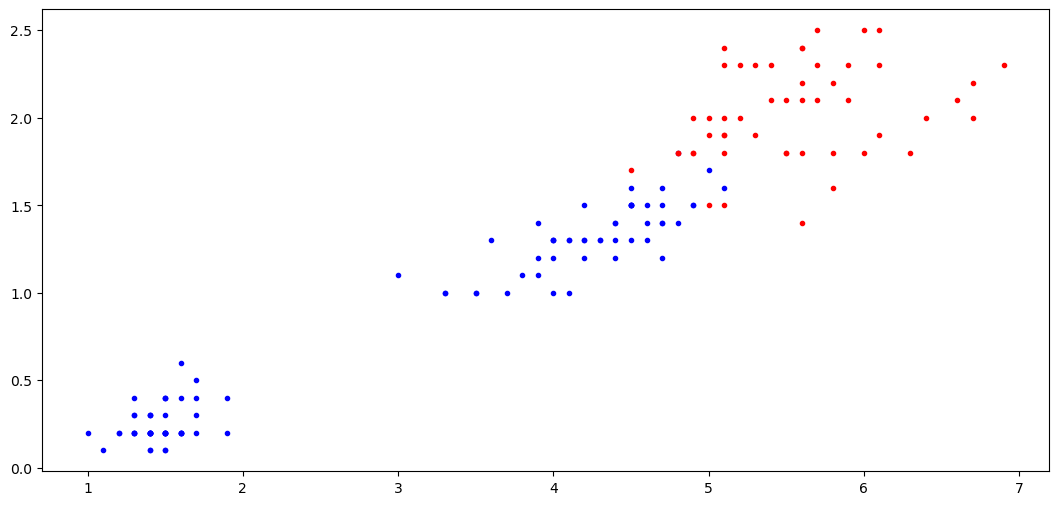

In [57]:
#representación gráfica del conjunto generado
plt.figure(figsize=(13,6))
plt.scatter(X[:,0][y==0],X[:,1][y==0], c = "b", marker = "." )
plt.scatter(X[:,0][y==1],X[:,1][y==1], c = "r", marker = "." )
plt.show()

In [62]:
#Entrenamos con Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X,y)

GaussianNB()

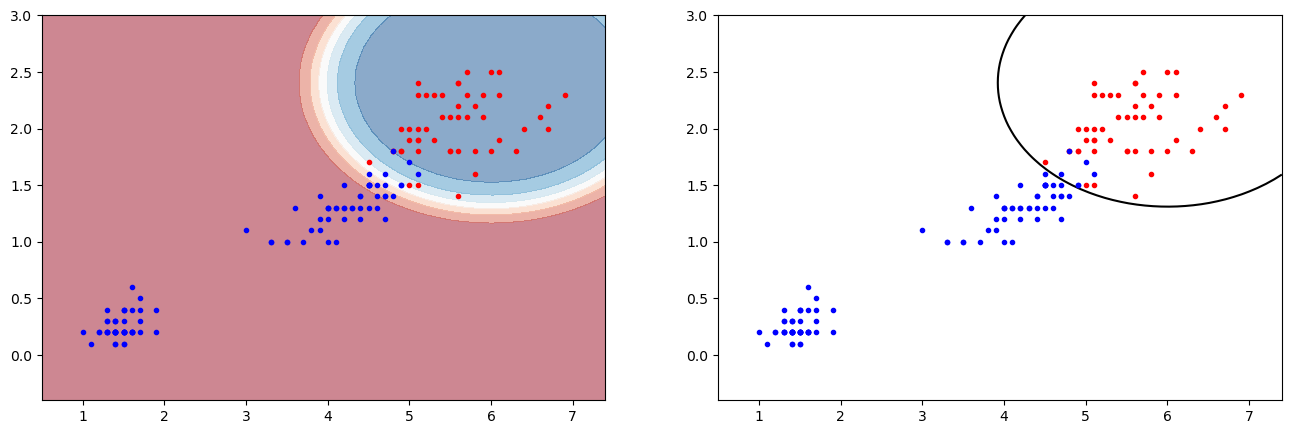

In [63]:
#Límite de decisión de Naive Bayes
plt.figure(figsize=(16,5))
plot_decision_boundary(X,y,clf)
plt.show()

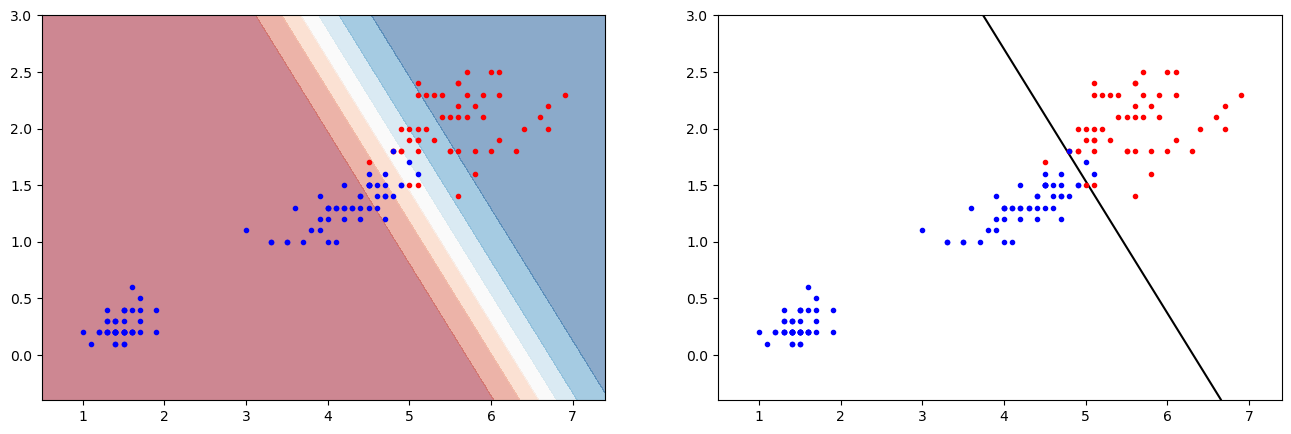

In [64]:
#Límite de decisión Regresión Logística
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X,y)
plt.figure(figsize=(16,5))
plot_decision_boundary(X,y,clf)
plt.show()